#### Imports

In [ ]:
import pandas as pd
import numpy as np
import bisect
from datetime import datetime, timedelta
from scipy.spatial import cKDTree
import pytz
import requests

#### 1. Read wildfire data and filter for 2024

In [2]:
import pandas as pd
import numpy as np

wildfire_file = "./WildFireData/fp-historical-wildfire-data-2006-2024.csv"
wildfire_df = pd.read_csv(wildfire_file)
wildfire_df = wildfire_df[['YEAR','LATITUDE','LONGITUDE','GENERAL_CAUSE', 'FIRE_START_DATE', 'FUEL_TYPE']]
wildfire_df = wildfire_df.rename(columns={'FIRE_START_DATE': 'START_DATE'})
wildfire_df = wildfire_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'START_DATE'])
wildfire_fuel_df = wildfire_df.dropna(subset=['FUEL_TYPE'])
wildfire2024_df = wildfire_fuel_df[wildfire_fuel_df['YEAR'] == 2024]
wildfire2024_df = wildfire2024_df.reset_index(drop=True)    # reset index
wildfire2024_df.to_csv('./WildFireData/wildfire2024.csv', index=False)
display(wildfire2024_df.head())
print(f"Number of wildfires in Alberta 2024: {len(wildfire2024_df)}")

,YEAR,LATITUDE,LONGITUDE,GENERAL_CAUSE,START_DATE,FUEL_TYPE
0,2024,55.199417,-112.400533,Agriculture Industry,2024-04-23 15:36:00,O1a
1,2024,56.766883,-111.724250,Recreation,2024-05-10 19:00:00,S1
2,2024,51.961340,-115.340712,Recreation,2024-05-20 15:33:00,C1
3,2024,58.712345,-111.188683,Government,2024-05-23 16:00:00,M2
4,2024,55.645667,-116.067867,Undetermined,2024-05-24 11:10:00,O1a


Number of wildfires in Alberta 2024: 1012


#### 2. Generate no-fire times for the same locations in 2024

##### Function for Randomly Generate Time in 2024

In [36]:
import bisect
from datetime import timedelta

# Time range
start_time = pd.to_datetime("2007-01-01")
end_time = pd.to_datetime("2024-12-31")
total_seconds = int((end_time - start_time).total_seconds())

def generate_random_times(n, existing_times):
    existing_times = sorted(existing_times)
    generated = []

    # Convert to list of timestamps in seconds since epoch for fast math
    existing_seconds = [pd.to_datetime(t).timestamp() for t in existing_times]
    generated_seconds = []

    attempts = 0
    max_attempts = 5000
    min_separation = 86400  # 24 hours in seconds

    while len(generated_seconds) < n and attempts < max_attempts:
        candidate = start_time + timedelta(seconds=np.random.randint(0, total_seconds))
        candidate_sec = candidate.timestamp()

        # Use bisect to insert into sorted list
        all_times = sorted(existing_seconds + generated_seconds)
        idx = bisect.bisect_left(all_times, candidate_sec)

        too_close = False
        if idx > 0 and abs(candidate_sec - all_times[idx - 1]) < min_separation:
            too_close = True
        elif idx < len(all_times) and abs(candidate_sec - all_times[idx % len(all_times)]) < min_separation:
            too_close = True

        if not too_close:
            generated.append(candidate)
            generated_seconds.append(candidate_sec)

        attempts += 1

    if len(generated_seconds) < n:
        print(f"Warning: Only generated {len(generated_seconds)} out of {n} due to 24-hour proximity rule.")

    return generated

##### Generate Time and Location for No Fire Entries

to guarantee we have information of the vegetation fuel type information that we will use as a feature, we can only use the locations recorded in the wildfire dataset. Here we assume that the vegetation fuel type of the location does not change over time.

###### all time

In [37]:
new_generate = True # Set to True to generate new data, False to load existing data

if new_generate:
    # Generate new data
    new_rows = []
    wildfire_df = pd.read_csv('./WildFireData/fp-historical-wildfire-data-2006-2024.csv')
    wildfire_df = wildfire_df[['YEAR','LATITUDE','LONGITUDE','GENERAL_CAUSE', 'FIRE_START_DATE', 'FUEL_TYPE']]
    wildfire_df = wildfire_df.rename(columns={'FIRE_START_DATE': 'START_DATE'})
    wildfire_df = wildfire_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'START_DATE'])
    wildfire_df = wildfire_df.dropna(subset=['FUEL_TYPE'])
    wildfire_df.to_csv('./WildFireData/wildfire_alltime.csv', index=False)
    wildfire_df[['LATITUDE_round', 'LONGITUDE_round']] = wildfire2024_df[['LATITUDE', 'LONGITUDE']].round(1)
    for (lat, lon), time_df in wildfire_df.groupby(['LATITUDE_round', 'LONGITUDE_round']):
        count = len(time_df)
        if count >= 50:
            num_to_generate = 1
        else:
            num_to_generate = 50 - count

        new_times = generate_random_times(num_to_generate, time_df['START_DATE'].tolist())
        for t in new_times:
            # append latitude and longitude of the original entry
            new_rows.append({
                'LATITUDE': time_df['LATITUDE'].values[0],
                'LONGITUDE': time_df['LONGITUDE'].values[0],
                'START_DATE': t,
                'FUEL_TYPE': time_df['FUEL_TYPE'].values[0]
            })

    # Create DataFrame of new entries
    df_new = pd.DataFrame(new_rows) # 6299 rows
    df_new['FIRE'] = False
    df_new.to_csv("./WildFireData/nonfire_alltime.csv", index=False)

    # Take only the date time and fuel information from the original data
    fire_loc_time_df = wildfire_df[['LATITUDE', 'LONGITUDE', 'START_DATE', 'FUEL_TYPE']]
    fire_loc_time_df['FIRE'] = True

    # Combine with original data
    all_loc_time_df = pd.concat([fire_loc_time_df, df_new], ignore_index=True)
    display(all_loc_time_df) # 7311 rows
    all_loc_time_df.to_csv("./WildFireData/wildfire&nonfire_alltime.csv", index=False)

else:
    # Load existing data
    wildfire_df = pd.read_csv('./WildFireData/wildfire_alltime.csv')
    display(wildfire_df)
    df_new = pd.read_csv('./WildFireData/nonfire_alltime.csv')
    all_loc_time_df = pd.read_csv('./WildFireData/wildfire&nonfire_alltime.csv')
    display(all_loc_time_df) # 7311 rows

C:\Users\hlllu\AppData\Local\Temp\ipykernel_168108\501315057.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_loc_time_df['FIRE'] = True


,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE
0,56.249956,-117.181960,2006-04-02 12:00:00,O1a,True
1,53.606367,-115.915733,2006-04-03 12:10:00,O1a,True
2,53.610933,-115.594267,2006-04-03 12:15:00,O1a,True
3,53.608867,-115.609467,2006-04-03 12:10:00,O1b,True
4,51.152933,-115.034600,2006-04-02 14:25:00,O1b,True
...,...,...,...,...,...
203172,56.332733,-110.975833,2022-05-03 10:34:21,C2,False
203173,56.332733,-110.975833,2018-06-03 00:33:55,C2,False
203174,56.332733,-110.975833,2007-07-09 04:39:31,C2,False
203175,56.332733,-110.975833,2015-07-25 02:13:05,C2,False


###### 2024

In [ ]:
new_generate = False  # Set to True to generate new data, False to load existing data

if new_generate:
    # Generate new data
    new_rows = []
    wildfire2024_df = pd.read_csv('./WildFireData/wildfire2024.csv')
    wildfire2024_df[['LATITUDE_round', 'LONGITUDE_round']] = wildfire2024_df[['LATITUDE', 'LONGITUDE']].round(1)
    for (lat, lon), time_df in wildfire2024_df.groupby(['LATITUDE_round', 'LONGITUDE_round']):
        count = len(time_df)
        if count >= 10:
            num_to_generate = 1
        else:
            num_to_generate = 10 - count

        new_times = generate_random_times(num_to_generate, time_df['START_DATE'].tolist())
        for t in new_times:
            # append latitude and longitude of the original entry
            new_rows.append({
                'LATITUDE': time_df['LATITUDE'].values[0],
                'LONGITUDE': time_df['LONGITUDE'].values[0],
                'START_DATE': t,
                'FUEL_TYPE': time_df['FUEL_TYPE'].values[0]
            })

    # Create DataFrame of new entries
    df_new = pd.DataFrame(new_rows) # 6299 rows
    df_new['FIRE'] = False
    df_new.to_csv("./WildFireData/nonfire2024_4.csv", index=False)

    # Take only the date time and fuel information from the original data
    fire_loc_time_df = wildfire2024_df[['LATITUDE', 'LONGITUDE', 'START_DATE', 'FUEL_TYPE']]
    fire_loc_time_df['FIRE'] = True

    # Combine with original data
    all_loc_time_df = pd.concat([fire_loc_time_df, df_new], ignore_index=True)
    display(all_loc_time_df) # 7311 rows
    all_loc_time_df.to_csv("./WildFireData/wildfire&nonfire2024_4.csv", index=False)

else:
    # Load existing data
    wildfire2024_df = pd.read_csv('./WildFireData/wildfire2024.csv')
    df_new = pd.read_csv('./WildFireData/nonfire2024.csv')
    all_loc_time_df = pd.read_csv('./WildFireData/wildfire&nonfire2024.csv')
    display(all_loc_time_df) # 7311 rows



,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True
1,56.766883,-111.724250,2024-05-10 19:00:00,S1,True
2,51.961340,-115.340712,2024-05-20 15:33:00,C1,True
3,58.712345,-111.188683,2024-05-23 16:00:00,M2,True
4,55.645667,-116.067867,2024-05-24 11:10:00,O1a,True
...,...,...,...,...,...
7306,59.979362,-111.832023,2024-10-17 21:24:17,M2,False
7307,59.979362,-111.832023,2024-07-01 12:45:19,M2,False
7308,59.979362,-111.832023,2024-03-21 06:31:49,M2,False
7309,59.979362,-111.832023,2024-06-10 03:03:54,M2,False


#### 3. Obtain Weather Data from OpenWeather API

##### Helper Functions
- EST to UTC time conversion
- OpenWeather API weather history call


In [21]:
from datetime import datetime
import pytz
import requests

def est_to_utc(est_time, time_format="%Y-%m-%d %H:%M:%S"):
    dt = datetime.strptime(str(est_time).strip(), time_format)

    # Localize to Toronto timezone and convert to UTC
    toronto_tz = pytz.timezone("America/Toronto")
    local_dt = toronto_tz.localize(dt)
    utc_dt = local_dt.astimezone(pytz.utc)

    return int(utc_dt.timestamp())

def fetch_weather_history(api_key, locations, save_path="./OpenWeatherData/OpenWeatherHistory2024Data.csv", count=24, save_every=100):
    base_url = "https://history.openweathermap.org/data/2.5/history/city"

    all_data = []

    index = 0

    for lat, lon, time in locations:
        try:
            if (est_to_utc(time) == 0):
                print(f"Skipped {lat, lon, time} due to timestamp: {time}")
                continue
            
            params = {
                "lat": lat,
                "lon": lon,
                "type": "hour",
                "start": est_to_utc(time),
                "cnt": count,
                "appid": api_key
            }

            print(f"Fetching data for ({lat}, {lon}) {time}...")
            try:
                response = requests.get(base_url, params=params)
                response.raise_for_status()
                data = response.json()

                if 'list' in data:
                    for entry in data['list']:
                        all_data.append({
                            "lat": lat,
                            "lon": lon,
                            "timestamp": entry["dt"],
                            "datetime": datetime.utcfromtimestamp(entry["dt"]),
                            "temp": entry["main"].get("temp"),
                            "pressure": entry["main"].get("pressure"),
                            "humidity": entry["main"].get("humidity"),
                            "wind_speed": entry["wind"].get("speed"),
                            "wind_deg": entry["wind"].get("deg"),
                            "weather": entry["weather"][0]["description"] if entry["weather"] else None
                        })
                    if (index + 1) % save_every == 0:
                        results = pd.DataFrame(all_data)
                        results.to_csv(save_path, index=False)
                        print(f"Saved progress at row {index+1} to {save_path}")
                    index += 1
                else:
                    print(f"No data returned for ({lat}, {lon})")

            except Exception as e:
                print(f"Error fetching data for ({lat}, {lon}): {e}")
            

        except:
            print(f"Skipped {lat, lon, time} due to timestamp: {time}")
            continue


    return pd.DataFrame(all_data)


##### Make API calls

In [22]:
fire_nonfire_df = pd.read_csv('./WildFireData/wildfire&nonfire2024_4.csv')
API_KEY = "b80fa3472414982ae4e0d191c7de5ec2"
call_weather_API = False # Set to True to call the API, False to load existing data
weather_file_path = "./OpenWeatherData/OpenWeatherHistory2024_4_2Data.csv"
if call_weather_API:
    locations = fire_nonfire_df[['LATITUDE', 'LONGITUDE', 'START_DATE']].values.tolist()
    weather_df = fetch_weather_history(API_KEY, locations, save_path=weather_file_path, count=1, save_every=100)
    display(weather_df)
else:
    # read csv to df such that first column is index
    weather_df = pd.read_csv(weather_file_path, index_col=0)
    display(weather_df)

,lat,lon,timestamp,datetime,temp,pressure,humidity,wind_speed,wind_deg,weather
0,49.392667,-114.438500,1717232400,2024-06-01 09:00:00,275.76,1017,79,1.62,194,broken clouds
1,49.392667,-114.438500,1715263200,2024-05-09 14:00:00,280.25,1029,86,1.08,359,scattered clouds
2,49.392667,-114.438500,1730408400,2024-10-31 21:00:00,275.23,1011,83,2.62,179,overcast clouds
3,49.392667,-114.438500,1717812000,2024-06-08 02:00:00,291.55,1009,35,1.40,298,clear sky
4,49.392667,-114.438500,1734760800,2024-12-21 06:00:00,274.26,1020,100,2.90,187,overcast clouds
...,...,...,...,...,...,...,...,...,...,...
7095,55.573467,-114.172283,1720900800,2024-07-13 20:00:00,293.16,1012,44,1.77,235,overcast clouds
7096,55.804333,-119.271167,1721613600,2024-07-22 02:00:00,300.33,1014,44,5.34,70,clear sky
7097,55.724083,-119.269417,1722801600,2024-08-04 20:00:00,289.09,1020,73,4.04,345,light rain
7098,54.216383,-118.201533,1723496400,2024-08-12 21:00:00,297.21,1004,32,1.76,347,scattered clouds


In [ ]:
#### HIDE THIS!!!! THIS IS JUST FOR TESTING PURPOSES DO NOT INCLUDE THIS IN FINAL REPORT!
# check all dates in fire_non_fire and print the number of entries before April 2nd 2024 and after April 2nd 2024 
before_date = pd.to_datetime("2024-04-02")
after_date = pd.to_datetime("2024-04-03")
fire_nonfire_df['START_DATE'] = pd.to_datetime(fire_nonfire_df['START_DATE'])
before_count = fire_nonfire_df[fire_nonfire_df['START_DATE'] < before_date].shape[0]
after_count = fire_nonfire_df[fire_nonfire_df['START_DATE'] >= after_date].shape[0]

print(f"Number of entries before April 2nd 2024: {before_count}")
print(f"Number of entries after April 2nd 2024: {after_count}")


# check number of entries that has FIRE = True and date before and after April 2nd 2024
fire_before_count = fire_nonfire_df[(fire_nonfire_df['FIRE'] == True) & (fire_nonfire_df['START_DATE'] < before_date)].shape[0]
fire_after_count = fire_nonfire_df[(fire_nonfire_df['FIRE'] == True) & (fire_nonfire_df['START_DATE'] >= after_date)].shape[0]

print(f"Number of FIRE entries before April 2nd 2024: {fire_before_count}")
print(f"Number of FIRE entries after April 2nd 2024: {fire_after_count}")

Number of entries before April 2nd 2024: 90
Number of entries after April 2nd 2024: 7201
Number of FIRE entries before April 2nd 2024: 72
Number of FIRE entries after April 2nd 2024: 940


##### Merge Weather data with Wildfire Data

In [35]:
weather_df = pd.read_csv('./OpenWeatherData/OpenWeatherHistory2024_4_2Data.csv', index_col=0)
fire_nonfire_df = pd.read_csv('./WildFireData/wildfire&nonfire2024_4.csv')
# round start date to the nearest day for merging dataframes
fire_nonfire_df['START_DATE_UTC'] = fire_nonfire_df['START_DATE'].apply(lambda x: est_to_utc(x))    # convert to standar UTC time
fire_nonfire_df['START_DATE_DAY'] = pd.to_datetime(fire_nonfire_df['START_DATE_UTC'], unit='s').dt.round('1D')
weather_df['start_day'] = pd.to_datetime(weather_df['datetime']).dt.round('1D')

display(fire_nonfire_df.head())
merged_df = pd.merge(fire_nonfire_df, weather_df, left_on=['LATITUDE', 'LONGITUDE', 'START_DATE_DAY'], right_on=['lat', 'lon', 'start_day'], how='inner')

# drop unused and duplicate columns
merged_df = merged_df.drop(columns=['START_DATE_UTC', 'START_DATE_DAY', 'lat', 'lon', 'timestamp', 'datetime', 'start_day'])
merged_df = merged_df.rename(columns={'temp': 'temperature'})
merged_df.to_csv("./OpenWeatherData/weather_fire_merged_4.csv", index=False)
display(merged_df.head())
print(merged_df['FIRE'].value_counts())

,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE,START_DATE_UTC,START_DATE_DAY
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True,1713900960,2024-04-24
1,56.766883,-111.724250,2024-05-10 19:00:00,S1,True,1715382000,2024-05-11
2,51.961340,-115.340712,2024-05-20 15:33:00,C1,True,1716233580,2024-05-21
3,58.712345,-111.188683,2024-05-23 16:00:00,M2,True,1716494400,2024-05-24
4,55.645667,-116.067867,2024-05-24 11:10:00,O1a,True,1716563400,2024-05-25


,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE,temperature,pressure,humidity,wind_speed,wind_deg,weather
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True,290.48,1012,24,1.26,179,few clouds
1,56.766883,-111.724250,2024-05-10 19:00:00,S1,True,299.39,1002,23,5.25,272,overcast clouds
2,51.961340,-115.340712,2024-05-20 15:33:00,C1,True,275.59,1015,95,1.85,354,light rain
3,58.712345,-111.188683,2024-05-23 16:00:00,M2,True,284.08,1016,49,2.26,68,overcast clouds
4,55.645667,-116.067867,2024-05-24 11:10:00,O1a,True,283.02,1007,60,4.32,113,overcast clouds


FIRE
False    6057
True      901
Name: count, dtype: int64


#### 4. Obtain Lightning Occurrences for these Time and Location

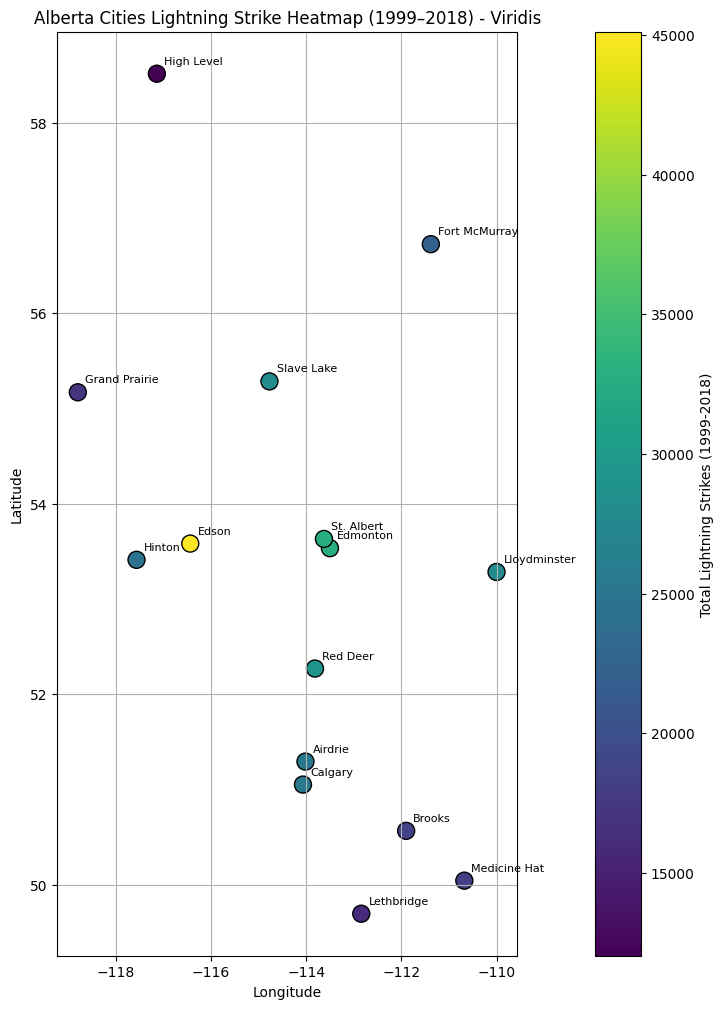

In [70]:
# THIS IS JUST FOR TESTING PURPOSES DO NOT INCLUDE THIS IN FINAL REPORT!
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv('./LightningData/lightning_cities_data.csv')

# Clean up city names and lightning strike numbers
df['City'] = df['City'].str.strip()
df['Total_Strikes'] = df['Total cloud-to-ground lightning flashes from 1999-2018'].str.replace(",", "").astype(int)

# Create scatter plot
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    df['Longitude'],
    df['Latitude'],
    c=df['Total_Strikes'],
    cmap='viridis',
    s=150,
    edgecolors='black'
)

# Annotate each point with the city name
for _, row in df.iterrows():
    plt.text(row['Longitude'] + 0.15, row['Latitude'] + 0.1, row['City'], fontsize=8)

# Add colorbar and labels
plt.colorbar(sc, label='Total Lightning Strikes (1999-2018)')
plt.title('Alberta Cities Lightning Strike Heatmap (1999–2018) - Viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
f = 1.0/np.cos(60*np.pi/180)
plt.gca().set_aspect(f, adjustable='box')
plt.grid(True)
plt.show()

In [47]:
merged_df = pd.read_csv("./OpenWeatherData/weather_fire_merged_4.csv")
lightning_df = pd.read_csv('./LightningData/lightning_cities_data.csv')
# rename columns to match
lightning_df = lightning_df.rename(columns={'Total cloud-to-ground lightning flashes from 1999-2018': 'lightning_count',
                                             'Average number of days with lightning (within 25 km)': 'avg_days_per_year'})

from scipy.spatial import cKDTree

# Step 1: KDTree on raw lat/lon
lightning_coords = lightning_df[['Latitude', 'Longitude']].to_numpy()
lightning_tree = cKDTree(lightning_coords)

query_coords = merged_df[['LATITUDE', 'LONGITUDE']].to_numpy()

# Step 2: Query k nearest cities
k = 5
dists, indices = lightning_tree.query(query_coords, k=k)

# Step 3: Inverse distance squared weighting (avoid divide-by-zero)
weights = 1 / np.clip(dists, 1e-6, None)**2  # 1/(distance)^2 weights

# Step 4: Weighted average of lightning metrics
# lightning_df['lightning_count'] = lightning_df['lightning_count'].astype(float)
# lightning_df['avg_days_per_year'] = lightning_df['avg_days_per_year'].astype(float)
lightning_counts = lightning_df['lightning_count'].str.replace(',', '').astype(float).values[indices]
avg_days = lightning_df['avg_days_per_year'].astype(float).values[indices]

weighted_counts = np.sum(lightning_counts * weights, axis=1) / np.sum(weights, axis=1)
weighted_days = np.sum(avg_days * weights, axis=1) / np.sum(weights, axis=1)

# Step 5: Add to DataFrame
merged_df['lightning_count_index'] = weighted_counts
merged_df['lightning_days_index'] = weighted_days

merged_df.to_csv("./LightningData/weather_fire_lightning_merged_2024.csv", index=False)
display(merged_df)


,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE,temperature,pressure,humidity,wind_speed,wind_deg,weather,lightning_count_index,lightning_days_index
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True,290.48,1012,24,1.26,179,few clouds,28551.070256,34.203486
1,56.766883,-111.724250,2024-05-10 19:00:00,S1,True,299.39,1002,23,5.25,272,overcast clouds,22565.247370,33.029316
2,51.961340,-115.340712,2024-05-20 15:33:00,C1,True,275.59,1015,95,1.85,354,light rain,30035.933387,38.757269
3,58.712345,-111.188683,2024-05-23 16:00:00,M2,True,284.08,1016,49,2.26,68,overcast clouds,25007.666405,33.236686
4,55.645667,-116.067867,2024-05-24 11:10:00,O1a,True,283.02,1007,60,4.32,113,overcast clouds,28139.097721,34.906081
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953,59.781383,-117.104483,2024-07-25 12:04:03,C2,False,294.84,1011,33,2.50,27,overcast clouds,14650.364000,28.513895
6954,59.781383,-117.104483,2024-12-04 12:02:22,C2,False,259.45,1025,91,4.14,198,overcast clouds,14650.364000,28.513895
6955,59.794133,-116.955917,2024-10-13 18:53:32,S2,False,285.80,1006,48,3.58,196,overcast clouds,14674.421956,28.324051
6956,59.794133,-116.955917,2024-07-18 14:29:53,S2,False,307.61,1007,20,4.35,219,clear sky,14674.421956,28.324051


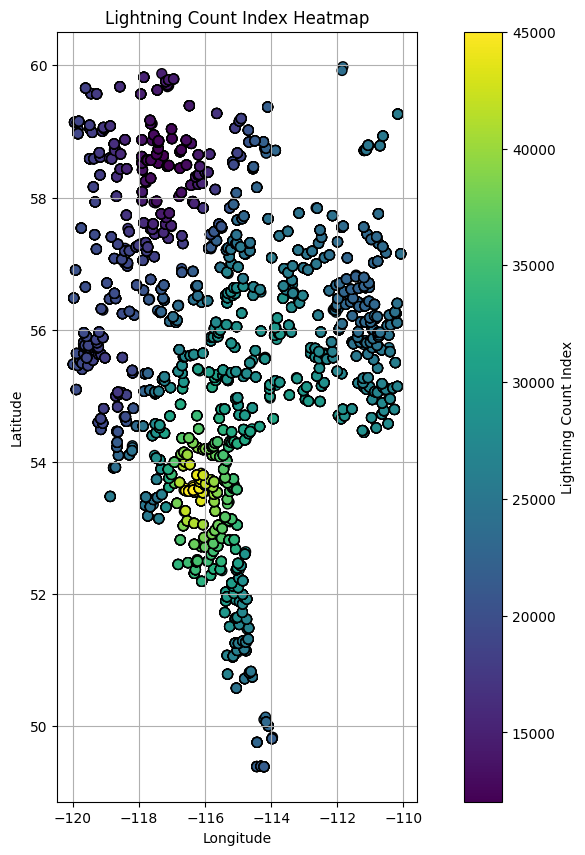

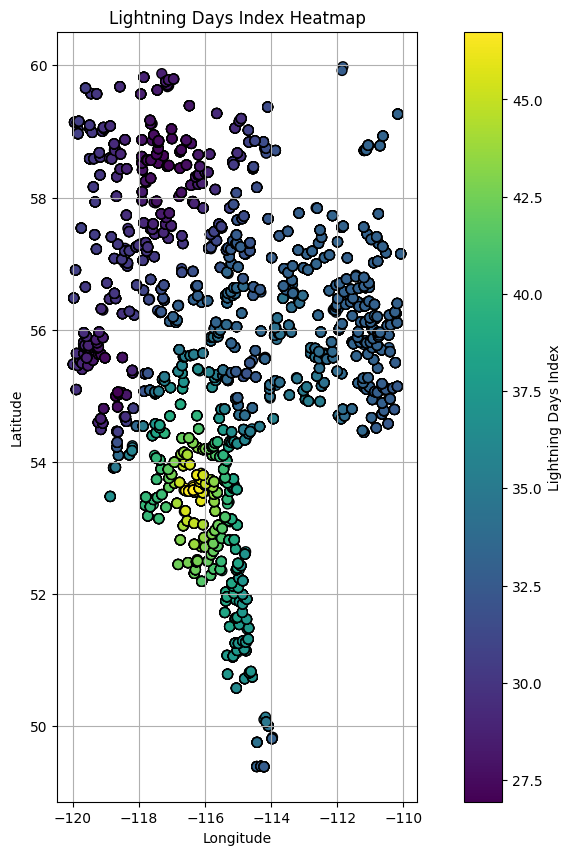

In [53]:
# THIS IS JUST FOR TESTING PURPOSES DO NOT INCLUDE THIS IN FINAL REPORT!
import matplotlib.pyplot as plt

# plot merged_df['lightning_count_index'] as heat map for all longitude and latitude values
plt.figure(figsize=(12, 10))
plt.scatter(merged_df['LONGITUDE'], merged_df['LATITUDE'], c=merged_df['lightning_count_index'], cmap='viridis', s=50, edgecolors='black')
plt.colorbar(label='Lightning Count Index')
plt.title('Lightning Count Index Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
f = 1.0/np.cos(60*np.pi/180)
plt.gca().set_aspect(f, adjustable='box')
plt.grid(True)
plt.show()

# plot merged_df['lightning_days_index'] as heat map for all longitude and latitude values
plt.figure(figsize=(12, 10))
plt.scatter(merged_df['LONGITUDE'], merged_df['LATITUDE'], c=merged_df['lightning_days_index'], cmap='viridis', s=50, edgecolors='black')
plt.colorbar(label='Lightning Days Index')
plt.title('Lightning Days Index Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
f = 1.0/np.cos(60*np.pi/180)
plt.gca().set_aspect(f, adjustable='box')
plt.grid(True)
plt.show()

#### 5. Obtain Population Density for these Location

In [56]:
merged_df = pd.read_csv("./LightningData/weather_fire_lightning_merged_2024.csv")
cities_df = pd.read_csv("./PopulationData/canadian_cities_with_coords.csv")
display(cities_df) # 119 rows

from scipy.spatial import cKDTree

urban_coords = cities_df[['latitude', 'longitude']].to_numpy()
urban_tree = cKDTree(urban_coords)

# Compute nearest urban center
def get_distance_to_urban(lat, lon):
    dist, idx = urban_tree.query([lat, lon], k=1)
    # also return the population density, dwelling count, and urban city type of the nearest urban center using its idx
    urban_density = cities_df.iloc[idx]['Population density per square kilometre, 2021']
    dwellings = cities_df.iloc[idx]['Total private dwellings, 2021']
    urban_type = cities_df.iloc[idx]['Geographic area type']
    # Geographic area types include 'Small population centre', 'Medium population centre', and 'Large urban population centre'
    # these labels are independent of the population density, for example the population density in Calgary (Large) is smaller than the population density in Airdrie (medium) and Chestermere (small)

    return dist*111, urban_type, urban_density, dwellings  # dist in degrees, multiply by ~111 km/deg for rough estimate

# Apply to df
merged_df[['dist_to_urban_km', 'urban_type', 'urban_population_density', 'urban_dwelling']] = pd.DataFrame(
    merged_df.apply(lambda row: get_distance_to_urban(row['LATITUDE'], row['LONGITUDE']), axis=1).tolist(),
    index=merged_df.index
)

display(merged_df)
merged_df.to_csv("./Processed/wildfire_features_merged_2024.csv", index=False)


,Geographic name,Geographic area type,Province or territory abbreviation,"Population, 2021","Population, 2016","Population percentage change, 2016 to 2021","Total private dwellings, 2021","Private dwellings occupied by usual residents, 2021","Land area in square kilometres, 2021","Population density per square kilometre, 2021",latitude,longitude
0,Airdrie,Medium population centre,Alta.,"73,578","61,082",20.5,"26,853","26,124",33.03,"2,227.30",51.285970,-114.010620
1,Alberta Beach - Val Quentin,Small population centre,Alta.,"1,103","1,327r",-16.9,"1,051",528,1.69,651.2,53.677947,-114.352253
2,Athabasca,Small population centre,Alta.,"1,181","1,250",-5.5,602,521,2.03,581.1,54.721454,-113.285794
3,Banff,Small population centre,Alta.,"8,305","7,851",5.8,"3,287","2,930",4.08,"2,033.80",51.177778,-115.568250
4,Barrhead,Small population centre,Alta.,"4,055","4,387",-7.6,"1,874","1,731",4.73,857.4,54.126236,-114.404412
...,...,...,...,...,...,...,...,...,...,...,...,...
114,Wembley,Small population centre,Alta.,"1,432","1,516",-5.5,616,550,2.20,651.5,55.153118,-119.143046
115,Westlake,Small population centre,Alta.,"2,040","1,363",49.7,654,635,3.27,624.7,52.256494,-113.843319
116,Westlock,Small population centre,Alta.,"4,820","4,957r",-2.8,"2,333","2,104",5.26,915.9,54.152524,-113.851990
117,Wetaskiwin,Small population centre,Alta.,"12,438","12,491r",-0.4,"5,584","5,136",12.11,"1,026.90",52.968492,-113.367920


,LATITUDE,LONGITUDE,START_DATE,FUEL_TYPE,FIRE,temperature,pressure,humidity,wind_speed,wind_deg,weather,lightning_count_index,lightning_days_index,dist_to_urban_km,urban_type,urban_population_density,urban_dwelling
0,55.199417,-112.400533,2024-04-23 15:36:00,O1a,True,290.48,1012,24,1.26,179,few clouds,28551.070256,34.203486,66.853982,Small population centre,726.2,991
1,56.766883,-111.724250,2024-05-10 19:00:00,S1,True,299.39,1002,23,5.25,272,overcast clouds,22565.247370,33.029316,37.499811,Medium population centre,"1,303.50","28,670"
2,51.961340,-115.340712,2024-05-20 15:33:00,C1,True,275.59,1015,95,1.85,354,light rain,30035.933387,38.757269,65.764253,Small population centre,872.8,"2,972"
3,58.712345,-111.188683,2024-05-23 16:00:00,M2,True,284.08,1016,49,2.26,68,overcast clouds,25007.666405,33.236686,221.243939,Medium population centre,"1,303.50","28,670"
4,55.645667,-116.067867,2024-05-24 11:10:00,O1a,True,283.02,1007,60,4.32,113,overcast clouds,28139.097721,34.906081,51.860726,Small population centre,872.7,969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6953,59.781383,-117.104483,2024-07-25 12:04:03,C2,False,294.84,1011,33,2.50,27,overcast clouds,14650.364000,28.513895,140.419996,Small population centre,"1,289.30","1,271"
6954,59.781383,-117.104483,2024-12-04 12:02:22,C2,False,259.45,1025,91,4.14,198,overcast clouds,14650.364000,28.513895,140.419996,Small population centre,"1,289.30","1,271"
6955,59.794133,-116.955917,2024-10-13 18:53:32,S2,False,285.80,1006,48,3.58,196,overcast clouds,14674.421956,28.324051,143.159701,Small population centre,"1,289.30","1,271"
6956,59.794133,-116.955917,2024-07-18 14:29:53,S2,False,307.61,1007,20,4.35,219,clear sky,14674.421956,28.324051,143.159701,Small population centre,"1,289.30","1,271"
